In [ ]:
import numpy as np


def euclidean_distance(X, Y):
    norm_x = (X ** 2).sum(axis=1)[:, np.newaxis]
    norm_y = (Y ** 2).sum(axis=1)
    minus = 2 * X @ Y.T
    return np.sqrt(norm_x + norm_y - minus)


def cosine_distance(X, Y):
    P = X @ Y.T
    P_norm = np.sqrt((X ** 2).sum(axis=1))[:, np.newaxis] @ np.sqrt((Y ** 2).sum(axis=1))[np.newaxis, :]
    return 1 - P / P_norm

In [ ]:

import sklearn.neighbors

class KNNClassifier:
    def __init__(self, k=5, strategy="brute", metric="euclidean", weights=False, test_block_size=None):
        self.k = k
        self.strategy = strategy
        self.str_metric = metric
        if metric == "euclidean":
            self.metric = euclidean_distance
        elif metric == "cosine":
            self.metric = cosine_distance
        self.weights = weights
        self.test_block_size = test_block_size
        self.model = None
        self.classes = None
        self.find_in_blocks = self.find_in_blocks
        self.y = None
        self.X = None

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y).astype(np.int)
        self.classes = np.max(self.y) + 1
        if self.strategy != "my_own":
            self.model = sklearn.neighbors.NearestNeighbors(
                n_neighbors=self.k,
                algorithm=self.strategy,
                metric=self.str_metric
            )
            self.model.fit(X)

    def find_kneighbors(self, X, return_distance=False):
        data = np.array(X)
        if return_distance:
            dist_matr = np.zeros((data.shape[0], self.k))
        else:
            dist_matr = None
        neighbors = np.zeros((data.shape[0], self.k))
        if self.test_block_size is None:
            block_size = data.shape[0]
        else:
            block_size = min(self.test_block_size, data.shape[0])
        N = data.shape[0] // block_size
        r = data.shape[0] % block_size
        if r != 0:
            N += 1
        left = 0
        if N == 1 and r != 0:
            right = r
        else:
            right = block_size
        for n in range(N):
            if return_distance:
                if self.strategy != "my_own":
                    dist_matr[left:right], neighbors[left:right] = \
                        self.model.kneighbors(data[left:right], self.k, return_distance)
                else:
                    dist_matr[left:right], neighbors[left:right] = \
                        self.find_in_blocks(data[left:right], return_distance)
            else:
                if self.strategy != "my_own":
                    neighbors[left:right] = self.model.kneighbors(data[left:right], self.k, return_distance)
                else:
                    neighbors[left:right] = self.find_in_blocks(data[left:right], return_distance)
            left += block_size
            if n == N - 2 and r != 0:
                right += r
            else:
                right += block_size
        if return_distance:
            return (dist_matr, neighbors)
        else:
            return neighbors

    def find_in_blocks(self, X, return_distance=False):
        distance = self.metric(X, self.X)
        neighbors = np.argsort(distance, axis=1)[:, 0:self.k]
        if return_distance:
            return (np.sort(distance, axis=1)[:, 0:self.k], neighbors)
        return neighbors

    def predict(self, X):
        votes = np.zeros((X.shape[0], self.classes))
        if self.weights:
            dist_matr, neighbors = self.find_kneighbors(X, True)
            eps = 0.00001
            for i in range(neighbors.shape[0]):
                for j in range(neighbors[i].shape[0]):
                    cl = int(neighbors[i][j])
                    ind = int(self.y[cl])
                    votes[i][ind] += 1 / (dist_matr[i][j] + eps)
            y_predict = np.argmax(votes, axis=1)
            return y_predict
        else:
            neighbors = self.find_kneighbors(X, False)
            dist_matr = None
            for i in range(neighbors.shape[0]):
                for j in range(neighbors[i].shape[0]):
                    cl = int(neighbors[i][j])
                    ind = int(self.y[cl])
                    votes[i][ind] += 1
            y_predict = np.argmax(votes, axis=1)
            return y_predict

In [ ]:
from copy import copy


def kfold(n, n_folds):
    lst = list(range(n))
    res = []
    size = n // n_folds
    r = n % n_folds
    left = 0
    right = None
    for i in range(n_folds):
        if i < r:
            cur_size = size + 1
        else:
            cur_size = size
        right = left + cur_size
        y_test = np.array(lst[left:right]).astype(int)
        if left == 0:
            y_train = np.array(lst[right:]).astype(int)
        elif right == 0:
            y_train = np.array(lst[:left]).astype(int)
        else:
            y_train = np.hstack((np.array(lst[:left]), np.array(lst[right:]))).astype(int)
        res.append((y_train, y_test))
        left += cur_size
    return res


def new_predict(model, neighbors, dist_matr=None):
    votes = np.zeros((neighbors.shape[0], np.max(model.y) + 1))
    if model.weights:
        eps = 0.00001
        for i in range(neighbors.shape[0]):
            for j in range(neighbors[i].shape[0]):
                cl = int(neighbors[i][j])
                ind = int(model.y[cl])
                votes[i][ind] += 1 / (dist_matr[i][j] + eps)
        y_predict = np.argmax(votes, axis=1)
        return y_predict
    else:
        for i in range(neighbors.shape[0]):
            for j in range(neighbors[i].shape[0]):
                cl = int(neighbors[i][j])
                ind = int(model.y[cl])
                votes[i][ind] += 1
        y_predict = np.argmax(votes, axis=1)
        return y_predict


def accuracy(y_true, y_pred):
    length = len(y_true)
    true_classes = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            true_classes += 1
    return true_classes / length


def knn_cross_val_score(X, y, k_list, score, cv=None, **kwargs):
    res = dict()
    if cv is None:
        folds = kfold(X.shape[0], 3)
    else:
        folds = cv
    model = KNNClassifier(k=k_list[-1], **kwargs)
    for s in folds:
        model.fit(X[s[0]], y[s[0]])
        dist = None
        if not model.weights:
            neighbors = model.find_kneighbors(X[s[1]], return_distance=False)
        else:
            (dist, neighbors) = model.find_kneighbors(X[s[1]], return_distance=True)
        for k in k_list[::-1]:
            if dist is not None:
                dist = dist[:, :k]
            neighbors = neighbors[:, :k]
            pred = new_predict(model, neighbors, dist)
            acc = accuracy(y[s[1]], pred)
            if k in res:
                res[k] = np.append(res[k], acc)
            else:
                res[k] = np.array([acc])
    return res


In [ ]:
import sklearn.datasets
mnist = sklearn.datasets.fetch_openml("mnist_784")

In [ ]:
X_train = mnist.data[:60000]
X_test = mnist.data[-10000:]
y_train = mnist.target[:60000].astype(int)
y_test = mnist.target[-10000:].astype(int)

Эксперимент №1

In [ ]:
import random
import time
for num in [10, 20, 100]:
    for strat in ['my_own', 'brute', 'kd_tree', 'ball_tree']:
        feat = np.random.randint(0, X_train.shape[1], num)
        model = KNNClassifier(k=5, strategy=strat, metric='euclidean', test_block_size=100)
        model.fit(X_train[:, feat], y_train)
        time1 = time.time()
        model.find_kneighbors(X_test[:, feat])
        time2 = time.time()
        print("n_features=", num, "strategy=", strat, "time=", time2-time1)


n_features= 10 strategy= my_own time= 75.15677118301392
n_features= 10 strategy= brute time= 14.639397621154785
n_features= 10 strategy= kd_tree time= 3.5054705142974854
n_features= 10 strategy= ball_tree time= 5.61193323135376
n_features= 20 strategy= my_own time= 76.1380066871643
n_features= 20 strategy= brute time= 14.766705513000488
n_features= 20 strategy= kd_tree time= 2.5451345443725586
n_features= 20 strategy= ball_tree time= 34.152029275894165
n_features= 100 strategy= my_own time= 80.0521297454834
n_features= 100 strategy= brute time= 19.6522696018219
n_features= 100 strategy= kd_tree time= 171.17884707450867
n_features= 100 strategy= ball_tree time= 168.02225399017334


Эксперимент №2

In [ ]:
import random
import time
time1 = time.time()
accur_k_eucl = knn_cross_val_score(X_train, y_train, list(range(1,11)), score='accuracy', strategy='brute', metric='euclidean', test_block_size=100)
time2= time.time()
time_eucl = time2 - time1
time1 = time.time()
accur_k_cos = knn_cross_val_score(X_train, y_train, list(range(1,11)), score='accuracy', strategy='brute', metric='cosine', test_block_size=100)
time2=time.time()
time_cos = time2 - time1

In [ ]:
k_neigh = np.arange(1,11)

In [ ]:
acc_k_neigh_eucl = np.zeros(10)
acc_k_neigh_cos = np.zeros(10)
for i in range(1,11):
    acc_k_neigh_eucl[i-1] = (accur_k_eucl[i][0] + accur_k_eucl[i][1] + accur_k_eucl[i][2]) / 3
    acc_k_neigh_cos[i-1] = (accur_k_cos[i][0] + accur_k_cos[i][1] + accur_k_cos[i][2]) / 3

In [ ]:
time_eucl, time_cos

(218.55022811889648, 278.59587836265564)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker

In [ ]:
plt.figure(figsize=(9,7))

plt.title('Зависимость точности работы алгоритма без весов от числа соседей')

width = 0.35

plt.bar(k_neigh - width / 2, acc_k_neigh_eucl, width, label='euclidean')
plt.bar(k_neigh + width / 2, acc_k_neigh_cos, width, label='cosine')

plt.xticks(k_neigh, k_neigh)

plt.ylim([0.96,0.975])

plt.xlabel('Число соседей')
plt.ylabel('Точность')

plt.legend(fontsize=10)
plt.savefig('graph1.svg')
plt.savefig('graph1.pdf')
plt.show()



Эксперимент №3

In [ ]:
time1 = time.time()
waccur_k_eucl = knn_cross_val_score(X_train, y_train, list(range(1,11)), score='accuracy', strategy='brute', metric='euclidean', weights=True, test_block_size=100)
time2= time.time()
wtime_eucl = time2 - time1
time1 = time.time()
waccur_k_cos = knn_cross_val_score(X_train, y_train, list(range(1,11)), score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=100)
time2=time.time()
wtime_cos = time2 - time1

In [ ]:
wacc_k_neigh_eucl = np.zeros(10)
wacc_k_neigh_cos = np.zeros(10)
for i in range(1,11):
    wacc_k_neigh_eucl[i-1] = (waccur_k_eucl[i][0] + waccur_k_eucl[i][1] + waccur_k_eucl[i][2]) / 3
    wacc_k_neigh_cos[i-1] = (waccur_k_cos[i][0] + waccur_k_cos[i][1] + waccur_k_cos[i][2]) / 3

In [ ]:
wtime_eucl, wtime_cos

(251.40140509605408, 320.29711723327637)

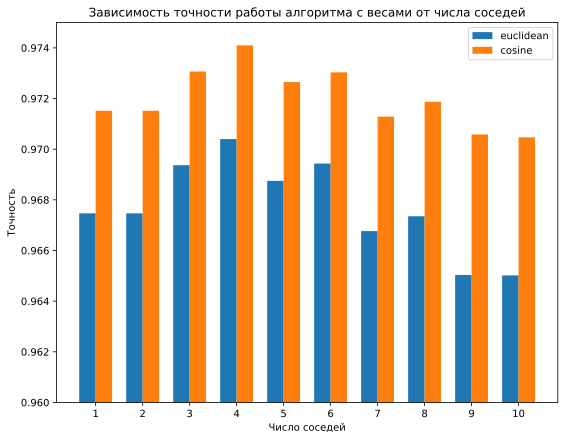

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(9,7))

plt.title('Зависимость точности работы алгоритма с весами от числа соседей')

width = 0.35

plt.bar(k_neigh - width / 2, wacc_k_neigh_eucl, width, label='euclidean')
plt.bar(k_neigh + width / 2, wacc_k_neigh_cos, width, label='cosine')

plt.xticks(k_neigh, k_neigh)

plt.ylim([0.96,0.975])

plt.xlabel('Число соседей')
plt.ylabel('Точность')

plt.legend(fontsize=10)
plt.savefig('graph2.svg')
plt.savefig('graph2.pdf')
plt.show()



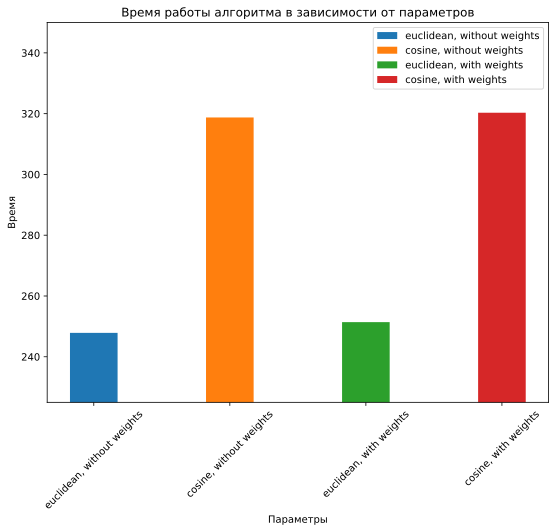

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(9,7))

plt.title('Время работы алгоритма в зависимости от параметров')

width = 0.35

idx = np.arange(1,5)

plt.bar(idx[0], time_eucl, width, label='euclidean, without weights')
plt.bar(idx[1], time_cos, width, label='cosine, without weights')
plt.bar(idx[2], wtime_eucl, width, label='euclidean, with weights')
plt.bar(idx[3], wtime_cos, width, label='cosine, with weights')

plt.xticks(idx, ['euclidean, without weights', 'cosine, without weights', 'euclidean, with weights', 'cosine, with weights'], rotation=45)

plt.ylim([225,350])

plt.xlabel('Параметры')
plt.ylabel('Время')

plt.legend(fontsize=10)

plt.savefig('graph3.svg')
plt.savefig('graph3.pdf')
plt.show()


Эксперимент №4

In [ ]:
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy(y_test, pred)

0.9752

In [ ]:
wacc_k_neigh_cos.max()

0.9741

In [ ]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(y_test, pred)

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

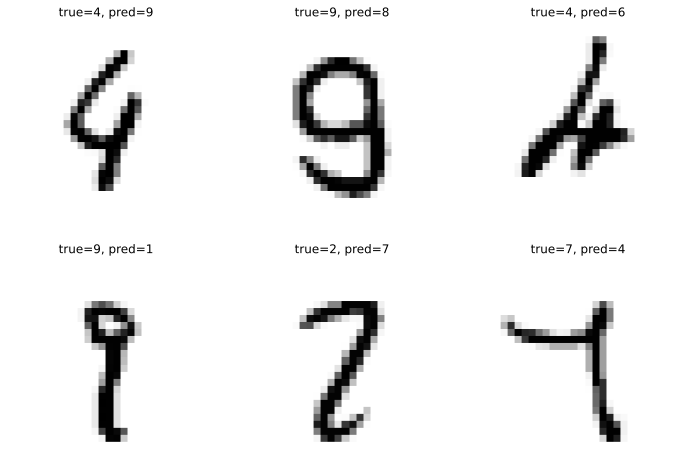

In [ ]:
fig, axes = plt.subplots(2, 3)
wrong_obj = X_test[y_test != pred]
true_ans = y_test[y_test != pred]
wrong_ans = pred[y_test != pred]
for i in range(2):
    for j in range(3):
        axes[i][j].imshow(wrong_obj[i*3+j].reshape(28,28), cmap='Greys')
        axes[i][j].axis('off')
        axes[i][j].set_title(label='true={0}, pred={1}'.format(true_ans[i*3+j], wrong_ans[i*3+j]))
fig.set_figwidth(12)
fig.set_figheight(8)   
plt.savefig('graph4.pdf')
plt.savefig('graph4.svg')

Эксперимент №5


In [ ]:
import scipy.ndimage as ndimage
import scipy.misc as misc
angles = [5,10,15]
shifts = [1,2,3]
disp = [0.5, 1, 1.5]

for a in angles:
    rot_X_train1 = np.zeros(X_train.shape)
    rot_X_train2 = np.zeros(X_train.shape)
    for i in range(X_train.shape[0]):
        rot_X_train1[i] = ndimage.rotate(X_train[i].reshape((28, 28)), a, reshape = False, prefilter = False).reshape(1,-1)
        rot_X_train2[i] = ndimage.rotate(X_train[i].reshape((28, 28)), -a, reshape = False, prefilter = False).reshape(1,-1)
    big_X_train = np.concatenate([X_train, rot_X_train1, rot_X_train2])
    big_y_train = np.concatenate([y_train, y_train, y_train])
    rot_accur = knn_cross_val_score(big_X_train, big_y_train, [4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    ac = (rot_accur[4][0] + rot_accur[4][1] + rot_accur[4][2]) / 3
    print("angle=", a, "accuracy=", ac)

angle= 5 accuracy= 0.9968833333333333
angle= 10 accuracy= 0.9735333333333333
angle= 15 accuracy= 0.9406777777777777


In [ ]:
import scipy.ndimage as ndimage
import scipy.misc as misc

shifts = [[0,1],[0,2],[0,3],[1,0],[2,0],[3,0]]
big_y_train = np.concatenate([y_train, y_train, y_train])
sh_X_train1 = np.zeros(X_train.shape)
big_X_train = list(range(6))
j = 0
for s in shifts:
    for i in range(X_train.shape[0]):
        sh_X_train1[i] = ndimage.shift(X_train[i].reshape((28, 28)), s).reshape(1,-1)
    big_X_train[j]=np.concatenate([X_train, sh_X_train1])
    j += 1
    

In [ ]:
big_y_train = np.concatenate([y_train, y_train])

In [ ]:
j = 0
for s in shifts:
    sh_accur = knn_cross_val_score(big_X_train[j], big_y_train, [4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    ac = (sh_accur[4][0] + sh_accur[4][1] + sh_accur[4][2]) / 3
    print("shift=", s, "accuracy=", ac)
    j+=1

shift= [0, 1] accuracy= 0.9832333333333333
shift= [0, 2] accuracy= 0.970125
shift= [0, 3] accuracy= 0.9689666666666668
shift= [1, 0] accuracy= 0.9830166666666665
shift= [2, 0] accuracy= 0.9701083333333332


In [ ]:
sh_accur = knn_cross_val_score(big_X_train[5], big_y_train, [4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=1000)
ac = (sh_accur[4][0] + sh_accur[4][1] + sh_accur[4][2]) / 3
print("shift= [3, 0]", "accuracy=", ac)

shift= [3, 0] accuracy= 0.9690249999999999


In [ ]:
disp_X_train = np.zeros(X_train.shape)
for d in disp:
    disp_X_train = np.zeros(X_train.shape)
    for i in range(X_train.shape[0]):
        disp_X_train[i] = ndimage.filters.gaussian_filter(X_train[i].reshape((28, 28)), d).reshape(1,-1)
    big_X_train = np.concatenate([X_train, disp_X_train])
    big_y_train = np.concatenate([y_train, y_train])
    disp_accur = knn_cross_val_score(big_X_train, big_y_train, [4], score='accuracy', strategy='brute', metric='cosine', weights=True, test_block_size=100)
    ac = (disp_accur[4][0] + disp_accur[4][1] + disp_accur[4][2]) / 3
    print("disp=", d, "accuracy=", ac)

disp= 0.5 accuracy= 1.0
disp= 1 accuracy= 0.9912833333333332
disp= 1.5 accuracy= 0.9798583333333334


In [ ]:
new_X_train1 = np.zeros(X_train.shape)
new_X_train2 = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    new_X_train1[i] = ndimage.shift(X_train[i].reshape((28, 28)), [0, 1]).reshape(1,-1)
    new_X_train2[i] = ndimage.filters.gaussian_filter(X_train[i].reshape((28, 28)), 1).reshape(1,-1)
new_X_train = np.concatenate([X_train, new_X_train1, new_X_train2])
new_y_train = np.concatenate([y_train, y_train, y_train])

In [ ]:
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
model.fit(new_X_train, new_y_train)
pred1 = model.predict(X_test)

In [ ]:
accuracy(y_test, pred1)

0.9825

In [ ]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(y_test, pred) - sklearn.metrics.confusion_matrix(y_test, pred1)

array([[ -1,   1,   0,   0,   0,   0,   1,  -1,   0,   0],
       [  0,  -1,   0,   1,   0,   0,   0,   0,   0,   0],
       [  3,  -1,  -1,  -1,   0,   0,  -1,  -3,   4,   0],
       [  0,   1,   2, -12,   0,   3,   0,   0,   5,   1],
       [  2,   1,   0,   0, -15,   0,   2,   0,   0,  10],
       [  2,  -1,   0,   4,   0,  -9,   3,   0,   2,  -1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   1,  -1,   0,  -2,  -1,   0,  -4,   0,   5],
       [  4,   1,   0,   7,   1,  -2,   3,   0, -15,   1],
       [  6,   3,   2,   3,   1,   1,   0,  -2,   1, -15]])

Эксперимент №6

In [ ]:
from scipy.stats import mode
angles = [5,10,15]
for a in angles:
    rot_X_test1 = np.zeros(X_test.shape)
    rot_X_test2 = np.zeros(X_test.shape)
    for i in range(X_test.shape[0]):
        rot_X_test1[i] = ndimage.rotate(X_test[i].reshape((28, 28)), a, reshape = False, prefilter = False).reshape(1,-1)
        rot_X_test2[i] = ndimage.rotate(X_test[i].reshape((28, 28)), -a, reshape = False, prefilter = False).reshape(1,-1)
    mod_rot = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
    mod_rot.fit(X_train, y_train)
    rot_X_test = np.concatenate([X_test, rot_X_test1, rot_X_test2])
    big_pred = mod_rot.predict(rot_X_test)
    pred = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        first = big_pred[i]
        second = big_pred[X_test.shape[0] + i]
        third = big_pred[2*X_test.shape[0] + i]
        if first == second or first == third:
            pred[i] = first
        elif second == third:
            pred[i] = second
        else:
            pred[i] = third
    ac = accuracy(pred, y_test)
    print("angle=", a, "accuracy=", ac)
    print(sklearn.metrics.confusion_matrix(y_test, pred))

angle= 5 accuracy= 0.9749
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    9    4    0]
 [   0    0    2  982    1    7    0    5    9    4]
 [   2    3    0    0  942    0    6    2    0   27]
 [   5    1    0    8    1  862    7    1    4    3]
 [   5    2    0    0    1    1  948    0    1    0]
 [   4   10    8    0    0    0    0  995    0   11]
 [   7    2    2    9    3    2    6    3  937    3]
 [   7    6    2    6    8    4    1    4    3  968]]
angle= 10 accuracy= 0.976
[[ 978    1    0    0    0    0    0    1    0    0]
 [   0 1128    3    2    0    0    2    0    0    0]
 [  10    0 1007    1    1    0    0   10    3    0]
 [   1    0    3  984    1    6    0    4    7    4]
 [   2    3    0    0  941    0    6    2    0   28]
 [   5    1    0    7    1  865    7    1    2    3]
 [   5    3    0    0    1    0  948    0    1    0]
 [   3    6    8    0    1    0    0  998    0

In [ ]:
for s in shifts:
    sh_X_test1 = np.zeros(X_test.shape)
    sh_X_test2 = np.zeros(X_test.shape)
    for i in range(X_test.shape[0]):
        sh_X_test1[i] = ndimage.shift(X_test[i].reshape((28, 28)), s).reshape(1,-1)
        minus_s = [-s[0], -s[1]]
        sh_X_test2[i] = ndimage.shift(X_test[i].reshape((28, 28)), minus_s).reshape(1,-1)
    mod_sh = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
    mod_sh.fit(X_train, y_train)
    sh_X_test = np.concatenate([X_test, sh_X_test1, sh_X_test2])
    big_pred = mod_sh.predict(sh_X_test)
    pred = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        first = big_pred[i]
        second = big_pred[X_test.shape[0] + i]
        third = big_pred[2*X_test.shape[0] + i]
        if first == second or first == third:
            pred[i] = first
        elif second == third:
            pred[i] = second
        else:
            pred[i] = third
    ac = accuracy(pred, y_test)
    print("shift=", s, "accuracy=", ac)
    print(sklearn.metrics.confusion_matrix(y_test, pred))

shift= [0, 1] accuracy= 0.9756
[[ 976    1    0    0    0    1    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    1 1007    1    0    0    0    9    6    0]
 [   0    1    1  982    0    9    0    6    7    4]
 [   2    5    0    0  951    0    5    3    0   16]
 [   3    0    0   11    1  864    6    1    4    2]
 [   5    3    0    1    1    1  947    0    0    0]
 [   2   13    4    0    0    0    0  998    0   11]
 [   5    1    1   12    3    2    5    4  938    3]
 [   4    6    4   10    8    2    1    5    5  964]]
shift= [0, 2] accuracy= 0.9479
[[ 960    0   10    1    0    1    3    1    0    4]
 [  12 1040    7    0    1    1   53    0   21    0]
 [   8    1 1005    6    0    0    0    8    4    0]
 [   0    3    7  964    1   16    0    8    7    4]
 [   0   12    2    0  942    0   10    2    4   10]
 [   5    0    0   23    1  842    4    2    6    9]
 [  11    3    0    1    1    9  930    0    3    0]
 [   1   17    7    0    2    0    1

In [ ]:
import scipy.ndimage as ndimage
sh_X_test1 = np.zeros(X_test.shape)
sh_X_test2 = np.zeros(X_test.shape)
for i in range(X_test.shape[0]):
    sh_X_test1[i] = ndimage.shift(X_test[i].reshape((28, 28)), [3,0]).reshape(1,-1)
    minus_s = [-3, -0]
    sh_X_test2[i] = ndimage.shift(X_test[i].reshape((28, 28)), minus_s).reshape(1,-1)
mod_sh = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
mod_sh.fit(X_train, y_train)
sh_X_test = np.concatenate([X_test, sh_X_test1, sh_X_test2])
big_pred = mod_sh.predict(sh_X_test)
pred = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    first = big_pred[i]
    second = big_pred[X_test.shape[0] + i]
    third = big_pred[2*X_test.shape[0] + i]
    if first == second or first == third:
        pred[i] = first
    elif second == third:
        pred[i] = second
    else:
        pred[i] = third
ac = accuracy(pred, y_test)
print("shift=", [3,0], "accuracy=", ac)
print(sklearn.metrics.confusion_matrix(y_test, pred))

shift= [3, 0] accuracy= 0.8148
[[ 897    0    7    0   16    0   28    1    1   30]
 [   0 1045    4    0    0    0   86    0    0    0]
 [  14    8  871   13   33    0   79    9    3    2]
 [  36    5   35  867    2   23   32    5    3    2]
 [   1   11    0    0  897    0    4   18   26   25]
 [  26    1   52   28   21  639   52    8   42   23]
 [  17    2    2    0   57    1  872    0    2    5]
 [   0   35   38   14   11    0    2  912    2   14]
 [  40   25   45   26    6   17  209   10  594    2]
 [   8   34   30   13  251    2    3   51   63  554]]


In [ ]:
import random
disp = [0.5, 1, 1.5]

for d in disp:
    disp_X_test1 = np.zeros(X_test.shape)
    for i in range(X_test.shape[0]):
        disp_X_test1[i] = ndimage.filters.gaussian_filter(X_test[i].reshape((28, 28)), d).reshape(1,-1)
    mod_disp = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=100)
    mod_disp.fit(X_train, y_train)
    disp_X_test = np.concatenate([X_test, disp_X_test1])
    big_pred = mod_disp.predict(disp_X_test)
    pred = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        pred[i] = random.choice([big_pred[i], big_pred[X_test.shape[0] + i]])
    ac = accuracy(pred, y_test)
    print("disp=", d, "accuracy=", ac)
    print(sklearn.metrics.confusion_matrix(y_test, pred))

disp= 0.5 accuracy= 0.9752
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1010    0    1    0    0    8    5    0]
 [   0    1    2  979    1   10    0    4    9    4]
 [   2    1    0    0  945    0    6    2    0   26]
 [   4    0    0   10    1  859    8    1    5    4]
 [   3    2    0    0    1    3  949    0    0    0]
 [   3   10    6    0    1    0    0  995    0   13]
 [   7    1    2    7    3    2    5    4  939    4]
 [   8    7    2    4    7    3    1    4    3  970]]
disp= 1 accuracy= 0.9691
[[ 976    1    0    0    0    0    2    1    0    0]
 [   0 1130    2    1    0    0    2    0    0    0]
 [  10    0 1002    1    1    0    2    9    7    0]
 [   3    3    3  968    0   11    0    5   12    5]
 [   2    1    2    0  926    0    8    3    2   38]
 [  11    1    0   10    1  850    6    1    8    4]
 [   5    2    0    0    1    1  949    0    0    0]
 [   2   15    4    0    2    0    0  987    1